## Milestone 3: Traditional statistical and machine learning methods

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

### Dataset Description

As a brief overview, in this portion of the project, we were tasked with creating models that would predict movie genre based on the features we had compiled in the past milestone. The way we structured our data, each movie in the dataset was assigned a label for each genre (1’s and 0’s). We decided we would train our models to predict each genre that the TMDB database provided. Additionally, we included a number of features from TMDB for each movie. Amongst these were features containing the actors and staff involved with the movie, the movie’s keywords, tagline, and overview, and its budget, popularity, revenue, runtime, and ratings. 

This week, we decided to add more feature data so that our models would be more robust. Specifically, we wanted to make use of the data given to us from TMDB and transform it into more useful features. Towards this end, we performed topic modeling and sentiment analysis on the descriptions of the movies. Specifically, we combined the keywords, tagline, and overview features into one sentence and assigned a polarity and subjectivity value to the sentence using Python’s TextBlob package; furthermore, we analyzed the top words per genre (such as “love”, “relationship”, “murder”) and added these to the dataset as indicator variables. We also decided to add data from the posters. To do this, we performed PCA on the posters and included the scores for each transformed movie poster in the dataset. Finally, rather than binary encoding the names of thousands of different actors, editors, and directors, we only kept the top 100 names of actors, supporting actors, directors, producers, and studios. 

After all these modifications to the dataset, however, we had nearly 600 columns/predictors, and so we decided to apply PCA to the dataset; interestingly, we found that PCA was quite effective, in that 97% of the variance of the data could be explained by just the first principal component, 2% by the second principal component, and negligible amounts by the subsequent components. Thus, we were able to decrease the size of our training set from nearly 600 predictors to less than a dozen! By reducing the dimensionality significantly, we made our model much more computationally efficient. 

### Metadata Dataset

In [1]:
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as sk_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from textblob import TextBlob

import gensim
import json
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os.path
import pandas as pd
import re
import string
import tmdb3 as tmdb

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 7})
%config InlineBackend.figure_format = 'png2x'

tmdb.set_key('98ca260f92ac9b42606914b232546089')

In [3]:
def get_genre_lst():
    genres = json.loads(tmdb.request.Request('/genre/movie/list').read())['genres']
    return [genre['name'] for genre in genres]

def get_top_matrix(df, column, n=100):
    values, counts = np.unique(df[column].dropna(), return_counts=True)
    top_n = values[np.argsort(counts)[::-1][:n]]
    names = ['{}.{}'.format(column, n) for n in range(n)]
    return pd.DataFrame([[(1 if t == l else 0) for t in top_n] for l in df[column]], index=df.index, columns=names)

def genre_freq(genre):
    # keep only the part of the dataframe that has movies in specific genre
    temp = movies[pd.notnull(movies['genres'])]
    indices = temp[temp['genres'].str.contains(genre)].index
    subset_new = new.ix[indices]
    subset_new = subset_new.dropna()
    # create an array for sentences
    sentences = []

    # implements vectorizer and gets rid of stop words like 'and' and 'there'
    vect = CountVectorizer(stop_words='english')
    # implements a stemmer to group words that have the same stems 
    stemmer = PorterStemmer()

    # iterate through the data  
    for index, row in subset_new.iterrows():
        # takes out the numbers from each sentence
        letters_only = re.sub('[^a-zA-Z]', ' ', row.text)
        # tokenize the sentence in order to stem the words
        tokenize = nltk.word_tokenize(letters_only)
        # finds the stem of each word 
        for i in range(len(tokenize)):
            tokenize[i] = stemmer.stem(tokenize[i]).lower()
        # appends each edited sentence (without numbers and with stems) to sentences array
        sentences.append(' '.join(tokenize))
    
    # create dictionary of frequency of each word
    words = [word for word in nltk.word_tokenize(''.join(sentences)) if word not in stopwords.words('english')]
    freq = nltk.FreqDist(words)
    
    # convert dictionary of frequencies to dataframe
    explore_freq = pd.DataFrame.from_dict(freq.most_common(20))
    explore_freq.columns = ['Words', 'Frequency']

    return(explore_freq)

def lda_topics(row):
    summary = row['overview']
    probs = ldamodel[dictionary.doc2bow((clean(unicode(summary, 'utf-8'))).split())]
    if len(probs) == 5:
        probs = [y for x,y in probs]
        return probs[0],probs[1],probs[2],probs[3],probs[4]
    else:
        indxs = [x for x,y in probs]
        if 0 not in indxs:
            probs.append((0,0.0))
        if 1 not in indxs:
            probs.append((1,0.0))
        if 2 not in indxs:
            probs.append((2,0.0))
        if 3 not in indxs:
            probs.append((3,0.0))
        if 4 not in indxs:
            probs.append((4,0.0))
        probs = sorted(probs, key=lambda tup: tup[0])
        probs = [y for x,y in probs]
        return probs[0],probs[1],probs[2],probs[3],probs[4]
    
def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [4]:
metadata_path = './datasets/metadata.pkl'

if not os.path.isfile(metadata_path):
    # Load milestone 2 datasets
    movies = pd.read_csv('./datasets/movies.csv', index_col='id')
    posters = pd.read_pickle('./datasets/posters_w185.pkl')

    # Drop movies without posters
    movies = movies.loc[movies['poster'].dropna().index]

    # Set up metadata dataset
    metadata = movies.drop(labels=['adult', 'countries', 'editor', 'releasedate', 'genres', 'poster'], axis=1)
        
genres = pd.read_pickle('./datasets/genres.pkl')

In [5]:
if not os.path.isfile(metadata_path):
    enc_columns = ['director', 'main_actor', 'producer', 'supporting_actor', 'studios']
    metadata_enc = pd.DataFrame()

    # Use binary encoding with the top 100 members of the 5 columns above
    for column in metadata.columns:
        if column in enc_columns:
            encoding = get_top_matrix(metadata, column)
            metadata_enc = pd.concat([metadata_enc, encoding], axis=1)
        else:
            metadata_enc = pd.concat([metadata_enc, metadata[column]], axis=1)

    metadata_enc.head(3)

In [6]:
if not os.path.isfile(metadata_path):
    # new dataframe just with the strings
    new = pd.DataFrame(metadata['keywords'] + ' ' + metadata['overview'] + ' ' + metadata['tagline'])
    new.columns = ['text']

    # save the null indices
    nullrows = []
    for i in range(new.shape[0]):
        if pd.isnull(new.iloc[i, 0]) == True: 
            nullrows.append(new.index[i])

    # try to replace null rows with some part of the word summaries
    for row in nullrows:
        if ((pd.isnull(metadata['tagline'][row]) == True) & 
            (pd.isnull(metadata['overview'][row]) == True) & (pd.isnull(metadata['keywords'][row]) == True)): 
            new.loc[row] = new.loc[row]
        elif (pd.isnull(metadata['tagline'][row]) == True) & (pd.isnull(metadata['overview'])[row] == True):
            new.loc[row] = metadata['keywords'][row]
        elif (pd.isnull(metadata['tagline'][row]) == True) & (pd.isnull(metadata['keywords'])[row] == True):
            new.loc[row] = metadata['overview'][row]
        elif (pd.isnull(metadata['keywords'][row]) == True) & (pd.isnull(metadata['overview'])[row] == True):
            new.loc[row] = metadata['tagline'][row]
        elif (pd.isnull(metadata['keywords'][row]) == True):
            new.loc[row] = metadata['tagline'][row] + ' ' + metadata['overview'][row]
        elif (pd.isnull(metadata['tagline'][row]) == True):
            new.loc[row] = metadata['keywords'][row] + ' ' + metadata['overview'][row]
        elif (pd.isnull(metadata['overview'][row]) == True):
            new.loc[row] = metadata['keywords'][row] + ' ' + metadata['tagline'][row]

    # drop any remaining 
    new = new.dropna()

In [7]:
if not os.path.isfile(metadata_path):
    #apply the sentiment analysis to each summary
    tok_reviews = []
    for i in range(0,new.shape[0]):
        tok_reviews.append(TextBlob(new.iloc[i, 0].decode('utf-8')).sentiment)

    # save polarity and subjectivity score
    new['tok_reviews'] = tok_reviews
    #create a series of the polarity and subjectivity score of each review
    new[['polarity', 'subjectivity']] = new['tok_reviews'].apply(pd.Series)

    polarity = []
    subjectivity = []

    for index in metadata.index:
        try:
            # append polarity & subjectivity scores if index exists in "new" dataframe
            polarity.append(new['polarity'][index])
            subjectivity.append(new['subjectivity'][index])
        except:
            # if that index was one of the ones removed & thus is null, we simply add 'Null' to the index
            # we can change this later based on how we want to approach this issue
            polarity.append(None)
            subjectivity.append(None)

    # new columns in metadata
    metadata['polarity'] = polarity
    metadata['subjectivity'] = subjectivity

In [8]:
if not os.path.isfile(metadata_path):
    top_vocab_words = []

    for genre in get_genre_lst():
        explore_freq = genre_freq(genre)
        for i in range(6,11):
            top_vocab_words.append(str(explore_freq.loc[i]['Words']))

    top_vocab_words = list(set(top_vocab_words))
    num_words = len(top_vocab_words)

    # create an array for sentences 
    sentences = []

    # implements vectorizer and gets rid of stop words like 'and' and 'there'
    vect = CountVectorizer(vocabulary = top_vocab_words)
    # implements a stemmer to group words that have the same stems 
    stemmer = PorterStemmer()

    # iterate through the data  
    for index, row in new.iterrows():
        # takes out the numbers from each sentence
        letters_only = re.sub('[^a-zA-Z]', ' ', row.text)
        # tokenize the sentence in order to stem the words
        tokenize = nltk.word_tokenize(letters_only)
        # finds the stem of each word 
        for i in range(len(tokenize)):
            tokenize[i] = stemmer.stem(tokenize[i]).lower()
        # appends each edited sentence (without numbers and with stems) to sentences array
        sentences.append(' '.join(tokenize))

    # create array of frequencies for each word 
    word_counts = vect.fit_transform(sentences).toarray()

In [9]:
if not os.path.isfile(metadata_path):
    original_columnsize = len(metadata.columns)

    # new columns for the top words
    for word in top_vocab_words:
        metadata[str(word)] = ''

    # keep track of word_counts count
    count = 0
    # keep track of metadata count
    overall = 0
    # add in the word counts to metadata
    for index in metadata.index:
        # if index isn't null, write in word_counts
        if index in new.index:
            metadata.iloc[overall, original_columnsize:original_columnsize+num_words] = word_counts[count]
            count = count + 1
        # else just put 0's for all the word counts
        else:
            metadata.iloc[overall, original_columnsize:original_columnsize+num_words] = np.zeros(word_counts.shape[1])
        overall = overall + 1

    metadata.head(2)

In [10]:
if not os.path.isfile(metadata_path):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()

    metadata.loc[pd.isnull(metadata.overview), 'overview'] = 'none'

    doc_complete = list(metadata['overview'])
    doc_clean = [(clean(unicode(doc, 'utf-8'))).split() for doc in doc_complete] 

    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

    probabs = metadata.apply(lda_topics, axis = 1)
    probabs = pd.DataFrame(probabs.tolist(), columns=['topic.{}'.format(n) for n in range(1, 6)], index=metadata.index)
    probabs.head()

In [11]:
if not os.path.isfile(metadata_path):
    # Merge the all metadata dfs
    metadata_txt = metadata.drop(labels=['director', 'keywords', 'main_actor', 'supporting_actor', 'tagline', 
                                         'title', 'overview', 'producer', 'studios'], axis=1)

    metadata_enc = metadata_enc.drop(labels=['budget', 'tagline', 'title', 'userrating', 'votes', 'keywords', 
                                             'overview', 'popularity', 'revenue', 'runtime'], axis=1)

    metadata_df = pd.concat([metadata_txt, metadata_enc, probabs], axis=1).loc[movies['genres'].dropna().index]
    metadata_df.to_pickle('./datasets/metadata.pkl')
else:
    metadata_df = pd.read_pickle('./datasets/metadata.pkl')
    
metadata_df.head(3)

,budget,popularity,revenue,runtime,userrating,votes,polarity,subjectivity,love,dure,...,supporting_actor.95,supporting_actor.96,supporting_actor.97,supporting_actor.98,supporting_actor.99,topic.1,topic.2,topic.3,topic.4,topic.5
id,,,,,,,,,,,,,,,,,,,,,
77,9000000,3.666593,39723096,113.0,8.0,2927,0.004938,0.626543,0,0,...,0,0,0,0,0,0.0,0.194190,0.000000,0.076904,0.71971
98,103000000,4.943334,457640427,155.0,7.8,4343,-0.030000,0.300000,0,0,...,0,0,0,0,0,0.0,0.977244,0.000000,0.000000,0.00000
107,10000000,4.769231,83557872,103.0,7.6,2414,-0.072500,0.420833,0,0,...,0,0,0,0,0,0.0,0.299851,0.683642,0.000000,0.00000


### Posters Dataset

In [12]:
STANDARD_SIZE = (75, 42)
def img_to_matrix(img):
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [13]:
pca_path = './datasets/pca_vects.csv'

if not os.path.isfile(pca_path):
    images = []
    
    for p in posters['poster']:
        p = p.convert('RGB')
        images.append(p)

    ims = [flatten_image(img_to_matrix(img)) for img in images]
    pca = RandomizedPCA(n_components=10)
    X = pca.fit_transform(ims)
    pca_vects = pd.DataFrame(X, index=posters.index, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5',
                                                              'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])
    pca_vects = pca_vects.loc[metadata_df.index]
    pca_vects.to_csv(pca_path)
    
else:
    pca_vects = pd.read_csv(pca_path, index_col=0)

### Models

We decided to implement two different models on our datasets -- a Random Forest Classifier and a Support Vector Machine. Recall from last milestone that we are using the “OnevsRestClassifier” function, which allows us to handle multilabel classification; we simply input a classifier (e.g.: RandomForest, SVM, etc) into the function and it outputs the probabilities that the classifier has assigned to each of the nineteen genres for every movie. 

We decided to use a Random Forest Classifier because random forests do not expect linear features or that features interact linearly; furthermore, random forests have the ability to handle high dimensional spaces and a large number of training samples. The parameters that we decided to tune for random forest were as follows: “gini” vs “entropy” criterion and the depth of each tree. Because we had already significantly cut down the number of features in the dataset through PCA, we did not think it necessary to tune n_features. After tuning, we found that the gini criterion, which chooses how to split decision trees by minimizing misclassification, performs essentially the same as entropy, which splits trees based on the highest amount of information gain. Furthermore, after tuning we found that trees with smaller depths (under 10) performed slightly better on the testing set, probably because trees with larger depths will overfit the training set. 

Like random forests, SVMs are also useful for modeling non-linear relations, which is why we chose this as our second classifier. We decided to use the rbf kernel over the linear kernel, because with so many genre labels, many that were quite correlated, we assumed that linear decision boundaries of the data would not be as effective. The parameters that we decided to tune for SVM were cost and gamma. Higher gamma values mean that the training sample should have a large influence on the model while lower gamma values mean they should have little influence; after cross validation, the best gamma parameter was 2, implying that the testing set score is higher when the training sample has less influence on the model fit. The cost similarly is extremely low, with the best parameter being 0.001; the lower the cost, the more train misclassifications there are, while higher costs severely penalize erroneous train classifications. Thus, since both the gamma and cost parameters are quite low, we see that the tuning of SVM aims at preventing overfitting of the training set on the model. 


#### Performance Metrics

Determining the correct performance metric to use was something of a challenge. We knew we wanted to split our data into test and train sets and then calculate accuracy on the test set, but it took us some time to come up with a useful way of defining accuracy. The scoring measure provided by the OneVsRest Function was too harsh of a metric, as it required that all labels for one movie be correct in order to count as “correctly classified;” with 19 different labels, some that are very similar to each other, it is not reasonable to judge the metric only if all 19 genres are predicted correctly. In other words, we believed there should be partial credit. So, for instance, if a movie was considered a “Romance” and “Drama”, but our model only classified it as “Romance”, we should still account this into our score function. 

Our first thought was to take the mean number of correct matches between the predicted binary values for each genre and the true values. At first, this looked promising, as we were getting test-accuracies of 0.88 with both Random Forest and SVM.

Further investigation indicated that something that was not right however. Training a model based on only the image-pca vectors produced an eerily similar test accuracy of 0.87. When we looked closer, we realized that all of our models were returning all 0’s for every prediction. 

To come up with a better metric for performance, we created an approach that focuses on labels that are 1 (meaning that movie is of that specific genre). For each movie, a set is created that is a union of the true genre labels that are 1 and the predicted genre labels that are 1. Accuracy is then calculated on this set. For instance, if the actual genre row is [0, 0, 0, 1, 0, 1] and the predicted row is [0, 0, 1, 0, 0, 1], we will only compare points 3, 4, and 7. We believe this approach is better than the previous approach because we are more interested in predicting when a movie is a specific genre than when it is not a specific genre.

In [14]:
def score_genres(model, x_test, y_test, threshold=0.25):
    predicted = np.array([[int(p > threshold) for p in row] for row in model.predict_proba(x_test)])
    means = []
    
    for pred, actual in zip(predicted, y_test):
        label_ind = np.unique(np.concatenate((np.nonzero(pred), np.nonzero(actual)), axis=1))
        means.append(np.mean(pred[label_ind] == actual[label_ind]))
        
    return np.mean(means)

def score_cost_gamma(x, y, min_c_power=-4, max_c_power=1, min_g_power=-2, max_g_power=2):
    costs = [10 ** p for p in range(min_c_power, max_c_power + 1)]
    gammas = [2 ** p for p in range(min_g_power, max_g_power + 1)]
    cv_scores = []
    
    # Test SVM accuracy
    for cost in costs:
        for gamma in gammas:
            model = OneVsRestClassifier(SVC(C=cost, gamma=gamma, probability=True), n_jobs=-1)
            score = np.mean(cross_val_score(model, x, y, scoring=score_genres, cv=5))
            cv_scores.append([score, cost, gamma])
            print score, cost, gamma
            
    # Find best cost and gamma
    max_score_ind = np.argmax(np.array(cv_scores)[:, 0])
    print 'Maximum accuracy: {:.3f}% with cost = {} and gamma = {}'.format(
        cv_scores[max_score_ind][0] * 100, cv_scores[max_score_ind][1], cv_scores[max_score_ind][2])
    
def score_criteria_depth(x, y, min_depth=1, max_depth=10):
    _, axes = plt.subplots(1, 2, figsize=(10, 3.5), dpi=125)
    depths = range(min_depth, max_depth + 1)

    for i in range(len(axes)):
        criterion = 'entropy' if i == 1 else 'gini'
        cv_test = []

        # Test RF accuracy
        for depth in depths:
            rf = OneVsRestClassifier(RandomForestClassifier(max_depth=depth,
                                                            criterion=criterion, n_jobs=-1), n_jobs=-1)
            rf.fit(x_train, y_train)
            score = np.mean(cross_val_score(rf, x, y, scoring=score_genres, cv=5))
            cv_test.append(score)

        # Plot accuracy lines
        axes[i].plot(depths, cv_test, color='#2196F3', linewidth=1)
        axes[i].set_title('Mean accuracy per maximum depth ({})'.format(criterion))
        axes[i].set_xlabel('Depth'); axes[i].set_ylabel('Accuracy')

    plt.tight_layout(); plt.show()
    
def threshold_scores(model):
    thresholds = np.arange(1.05, step=0.05)
    scores = [score_genres(model, x_test, y_test, t) for t in thresholds]

    plt.figure(figsize=(6, 3.5), dpi=125)
    plt.plot(thresholds, scores, color='#2196F3', linewidth=1)
    plt.title('Mean accuracy per threshold')
    plt.xlabel('Threshold'); plt.ylabel('Accuracy')
    plt.show()

In [15]:
pca = PCA(n_components=5)
pca.fit(metadata_df.as_matrix())

for ind, var in enumerate(pca.explained_variance_ratio_):
    print 'PC{}: {:.3}%'.format(ind + 1, var * 100)

PC1: 97.6%
PC2: 2.43%
PC3: 1.04e-09%
PC4: 5.1e-12%
PC5: 1.12e-14%


Almost all variance in our dataset can be explained with just the first two PCA components, so we will use them to fit our models:

### Model 1: SVM

In [16]:
# tuning svm on PCA components = 2
pca = PCA(n_components=2)
pca.fit(metadata_df.as_matrix())
x_reduced = pca.transform(metadata_df.as_matrix())

score_cost_gamma(x_reduced, genres.as_matrix())

0.264380480986 0.0001 0.25
0.253360492743 0.0001 0.5
0.279891352299 0.0001 1
0.272380590129 0.0001 2
0.279863469008 0.0001 4
0.279889337256 0.001 0.25
0.279869424871 0.001 0.5
0.279891352299 0.001 1
0.272370627985 0.001 2
0.279863469008 0.001 4
0.279889337256 0.01 0.25
0.279889337256 0.01 0.5
0.279891352299 0.01 1
0.279881390155 0.01 2
0.279863469008 0.01 4
0.279895310972 0.1 0.25
0.279889337256 0.1 0.5
0.279891352299 0.1 1
0.279881390155 0.1 2
0.279863469008 0.1 4
0.279889337256 1 0.25
0.279889337256 1 0.5
0.279891352299 1 1
0.279881390155 1 2
0.279863469008 1 4
0.279895310972 10 0.25
0.279889337256 10 0.5
0.279891352299 10 1
0.279881390155 10 2
0.279863469008 10 4
Maximum accuracy: 27.990% with cost = 0.1 and gamma = 0.25


In [17]:
# tuning svm on PCA components = 2
pca = PCA(n_components=2)
pca.fit(metadata_df.as_matrix())
x_reduced = pca.transform(metadata_df.as_matrix())

In [18]:
# svm on pca components = 2 after tuning
x_train, x_test, y_train, y_test = sk_split(x_reduced, genres.as_matrix(), train_size=0.8)

svm_model = OneVsRestClassifier(SVC(C=0.001, gamma=2, probability=True), n_jobs=-1)
svm_model.fit(x_train, y_train)
score_genres(svm_model, x_test, y_test, 0.25)

0.24294745974853502

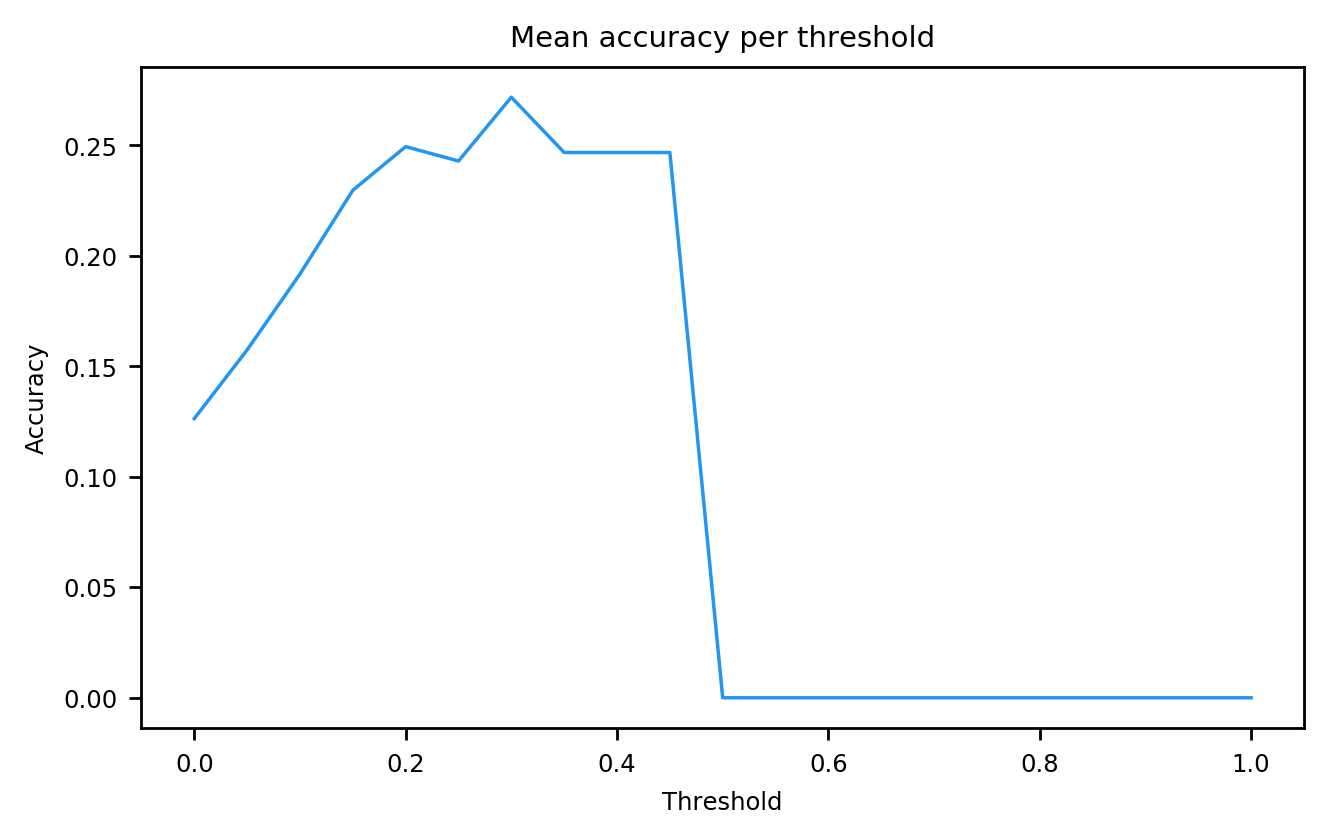

In [19]:
# how score changes with different thresholds
threshold_scores(svm_model)

This is not included here since it would make the notebook unnecessarily long, but we tested all thresholds with the random forest classifier models, but 0.25 still had the best performance. 

### Model 2: Random Forest

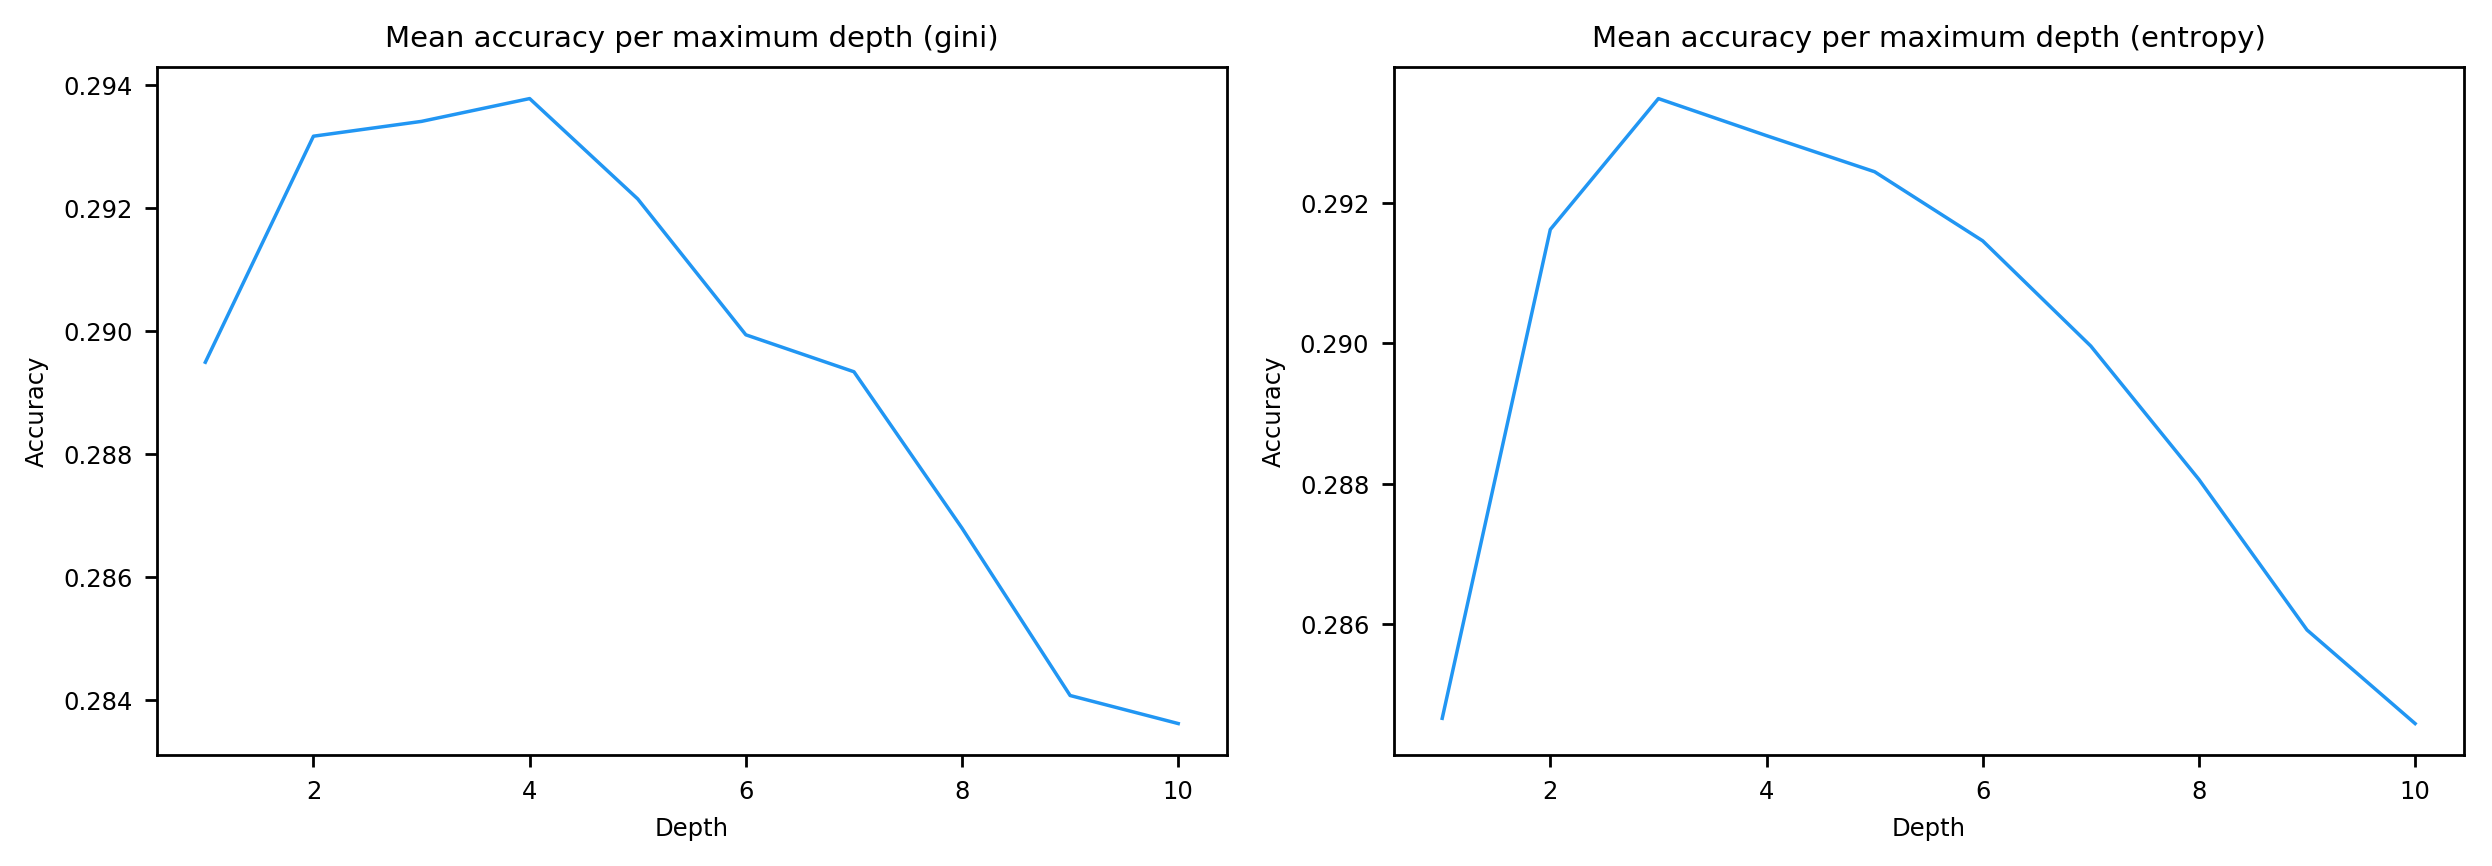

In [20]:
# tuning random forest for criterion and depth
score_criteria_depth(x_reduced, genres.as_matrix())

In [21]:
# Use depth=3 and criterion='gini' from the graphs above
rf_model = OneVsRestClassifier(RandomForestClassifier(max_depth=3, n_jobs=-1), n_jobs=-1)
rf_model.fit(x_train, y_train)
score_genres(rf_model, x_test, y_test)

0.2838951470671901

We find that the random forest model performs marginally better than SVM on our metadata dataset, and so we will explore the random forest model further by seeing how a model fit just on the poster PCA vectors does as well as how a model fit on the poster PCA vectors combined with metadata does. 

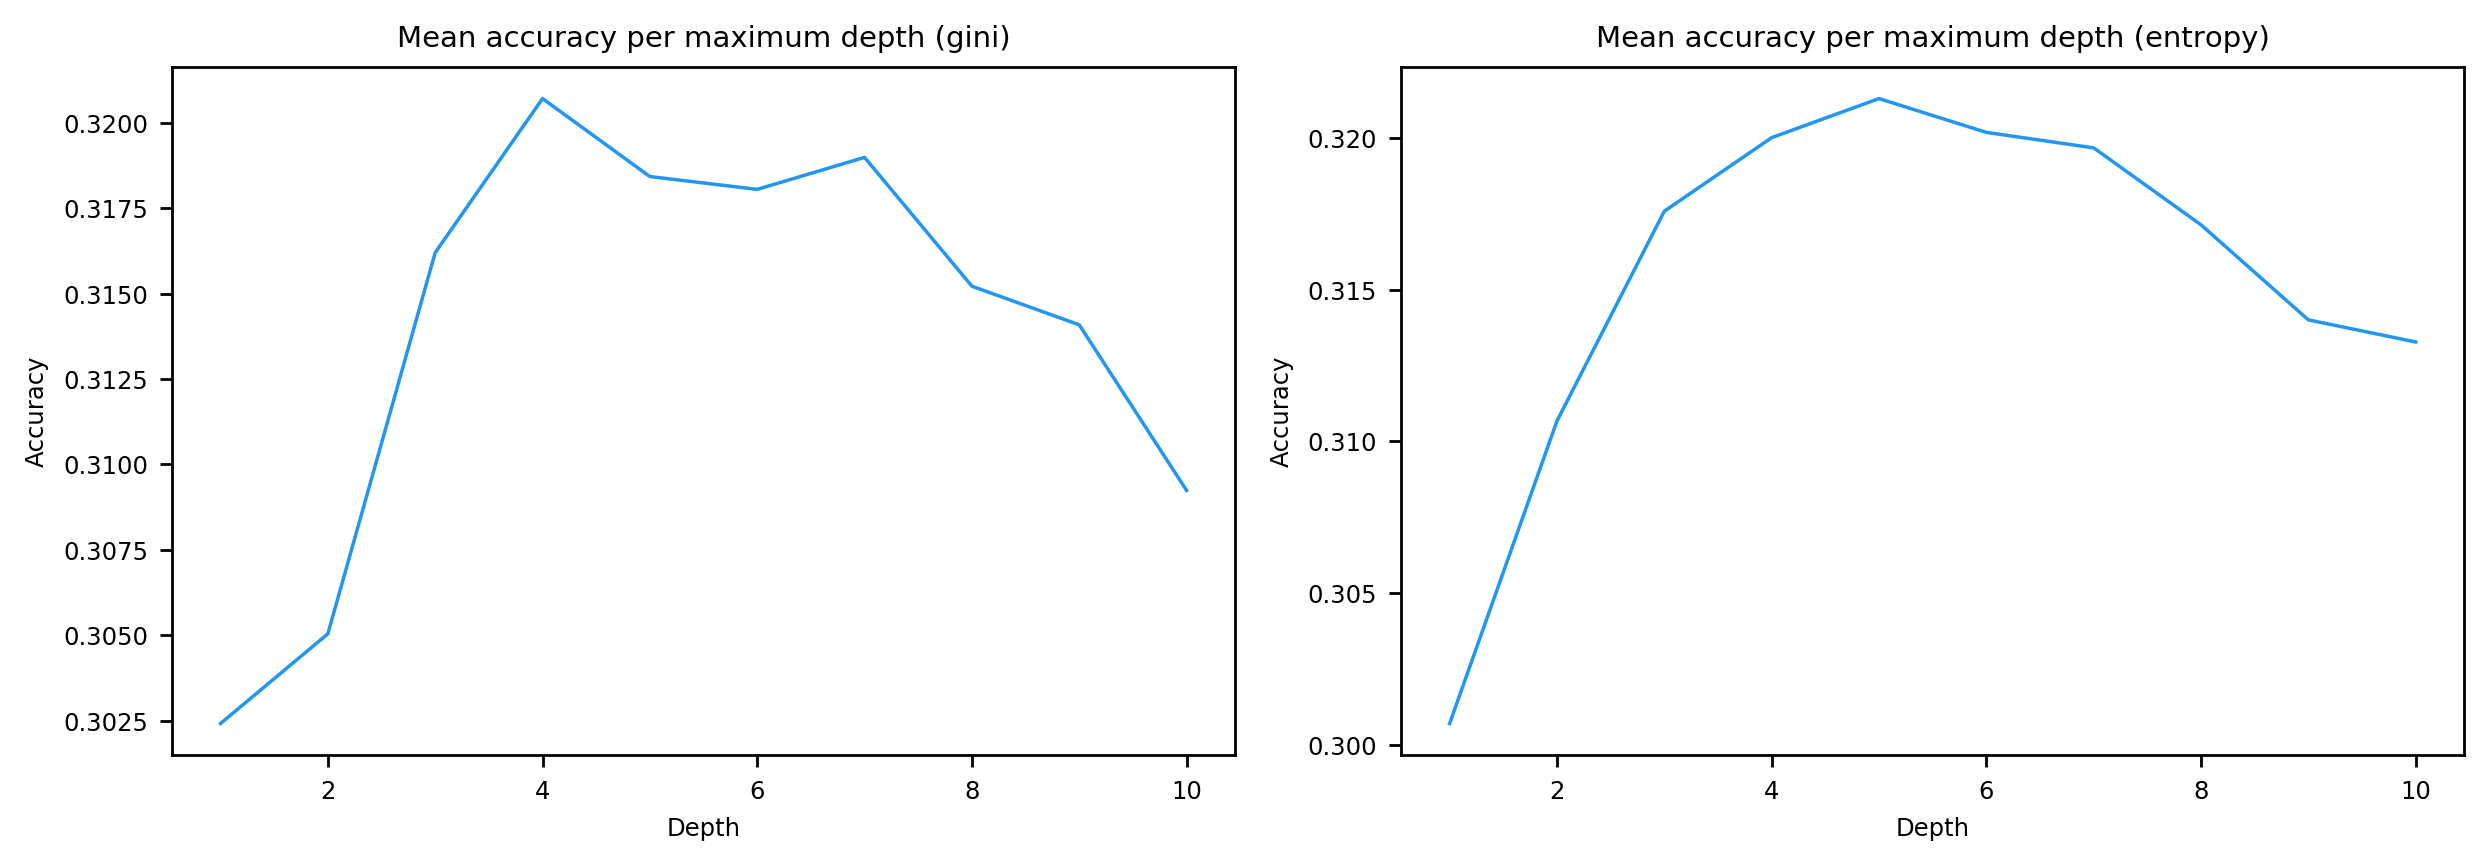

In [22]:
# tune random forest on just poster pca vectors
score_criteria_depth(pca_vects.as_matrix(), genres.as_matrix())

It seems that using just the poster PCA vectors can result is slighly better predictions with a random forest classifier. Let us see what happens when we append them to the original dataset before reducing it.

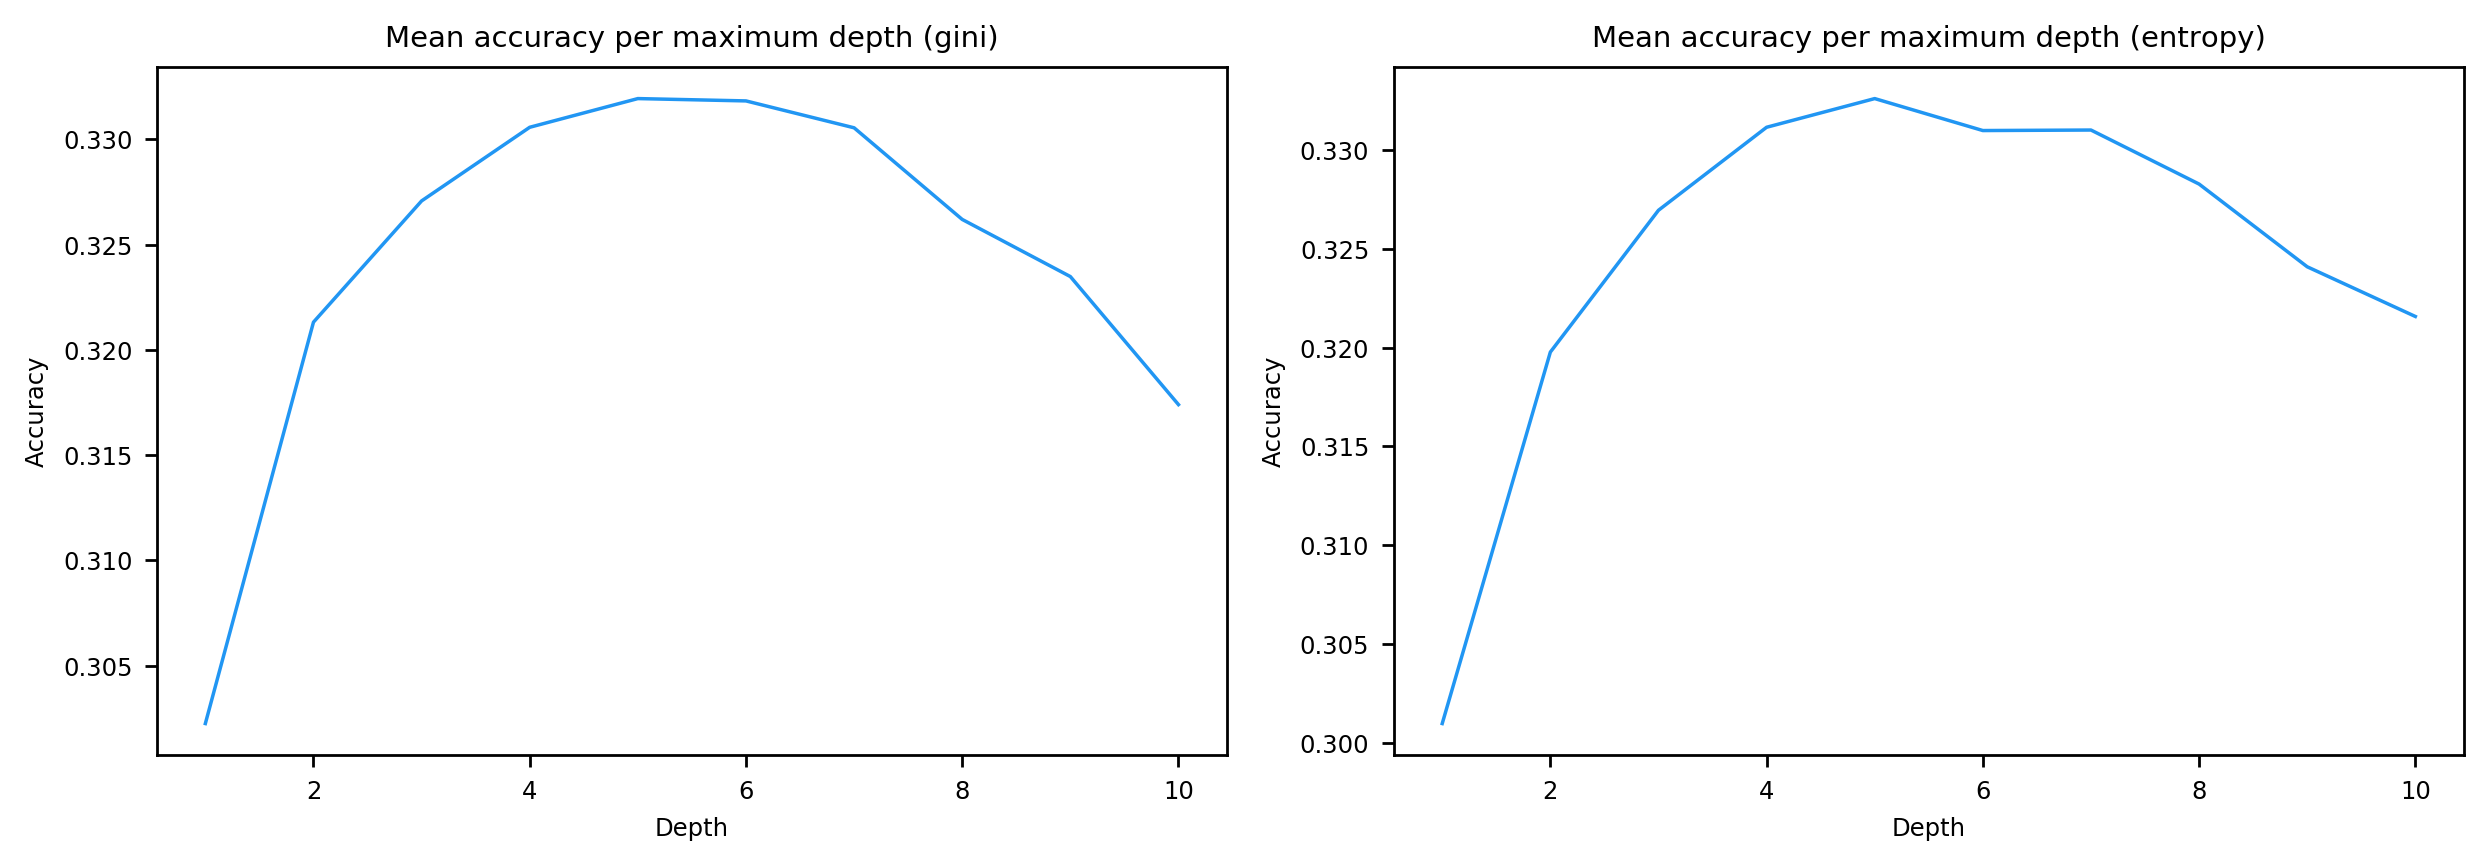

In [23]:
# tune random forest on merged dataset (that includes metadata and poster pca)
metadata_pca = pd.concat([metadata_df, pca_vects], axis=1)

pca = PCA(n_components=3)
pca.fit(metadata_pca.as_matrix())
pca_reduced = pca.transform(metadata_pca.as_matrix())

score_criteria_depth(pca_reduced, genres.as_matrix())

Combining the metadata with the poster PCA vectors gives us a marginal improvement in accuracy, so we will use this new dataset with `max_depth=5` and `criterion=entropy`:

In [24]:
xp_train, xp_test, yp_train, yp_test = sk_split(pca_reduced, genres.as_matrix(), train_size=0.8)

# Use depth=5 and criterion='entropy' from the graphs above
rf_pca_model = OneVsRestClassifier(RandomForestClassifier(criterion='entropy', max_depth=5, n_jobs=-1), n_jobs=-1)
rf_pca_model.fit(xp_train, yp_train)
score_genres(rf_pca_model, xp_test, yp_test)

0.33406700991826438

### Differences Between Models

The “Descriptions of Our Models” section largely covers the strengths of each model. In this particular problem, the main differences between the two models were not immediately apparent. Knowledge of how each model works, however, gives some insight into what makes RandomForest stronger in some scenarios and SVM stronger in others.

Importantly, SVM should perform better in high-dimensional space. Random Forest, on the other hand, should perform better when there is a large amount of data. Random Forest should also be faster to train. Here, we believe that Random Forest slightly outperformed SVM because there was a huge amount of data (about 8500 movies). In addition, PCA brought the dataset down to only a few features, so SVM should not have had an advantage there.

### Conclusion

As described in the “Performance Metrics” section, we eventually settled on calculating accuracy by focusing on both the genres that were supposed to be present and the genres that were predicted. We achieved 28% test-set accuracy using tuned SVM with a radial kernel and an adjusted probability threshold. Originally, our model would classify a movie a certain genre if the probability to be that genre was over 0.5. However, we found that this threshold was too high, because generally the model would assign relatively low probabilities to each genre (probably because the dataset is so large that the genre appears quite infrequently). After reducing the threshold to 0.25, we found that the model assigned 1’s to genres more liberally, and hence the score (using our score function) increased. 

We also trained a Random Forest model and the cross-validated accuracy was slightly higher (a little over 29%), particularly after reducing the probability threshold as we did in our SVM model. We then tuned a new Random Forest model using the 10 top image-pca vectors and another model with a combination of our metadata features and the image-pca vectors. The latter marginally outperformed all other models with a cross-validated accuracy of 33.5%. 

Though a test accuracy of 0.35 is certainly not the most impressive accuracy anyone has ever seen, we believe this is a challenging problem and it is a good start without using any Deep Learning methods.

We believe that perhaps some more feature engineering could improve the score. Particularly, we could look into more natural language processing for the movie summary. We could also incorporate movie reviews into the dataset by performing sentiment analysis and topic modeling on them. 